In [ ]:
# Start from simple example network and 2022 code of David

In [ ]:
import matplotlib.pyplot as plt
import pandapower as pp
import pandas as pd
import simbench as sb

## Pandapower Basics

Dokumentation: https://pandapower.readthedocs.io/en/latest/about.html.

Konvention fuer Namen von Einheiten: \<parameter\>\_\<unit\> oder \<parameter\>\_\<phase\>\_\<unit\>. Beispiel: vn_kv -> $v_n[kV]$. Naehere Infos in Function Docstring oder in der Dokumentation.

Wir bauen ein minimales Netz aus einzelnen Komponenten auf.

In [77]:
#create empty net
my_net = pp.create_empty_network()

In [78]:
my_net

This pandapower network is empty

In [79]:
#create buses
bus1 = pp.create_bus(my_net, vn_kv=20., name="Bus 1")
bus2 = pp.create_bus(my_net, vn_kv=0.4, name="Bus 2")
bus3 = pp.create_bus(my_net, vn_kv=0.4, name="Bus 3")

In [82]:
my_net.bus

,name,vn_kv,type,zone,in_service
0,Bus 1,20.0,b,None,True
1,Bus 2,0.4,b,None,True
2,Bus 3,0.4,b,None,True


In [105]:
# The returned value is the index of the element in its table
print(type(bus1), bus1)

<class 'numpy.int64'> 0


In [83]:
#create bus elements
pp.create_ext_grid(my_net, bus=bus1, vm_pu=1.02, name="Grid Connection") # erstellt externes netz
pp.create_load(my_net, bus=bus3, p_mw=0.100, q_mvar=0.05, name="Load") # erstellt last

0

In [109]:
#create branch elements
trafo = pp.create_transformer(my_net, hv_bus=bus1, lv_bus=bus2, std_type="0.4 MVA 20/0.4 kV", name="Trafo")
line = pp.create_line(my_net, from_bus=bus2, to_bus=bus3, length_km=0.1, std_type="NAYY 4x50 SE", name="Line")

In [110]:
my_net

This pandapower network includes the following parameter tables:
   - bus (3 element)
   - load (1 elements)
   - ext_grid (1 elements)
   - line (1 elements)
   - trafo (1 elements)

In [112]:
my_net.line

,name,std_type,from_bus,to_bus,length_km,r_ohm_per_km,x_ohm_per_km,c_nf_per_km,g_us_per_km,max_i_ka,df,parallel,type,in_service
0,Line,NAYY 4x50 SE,1,2,0.1,0.642,0.083,210.0,0.0,0.142,1.0,1,cs,True


No or insufficient geodata available --> Creating artificial coordinates. This may take some time


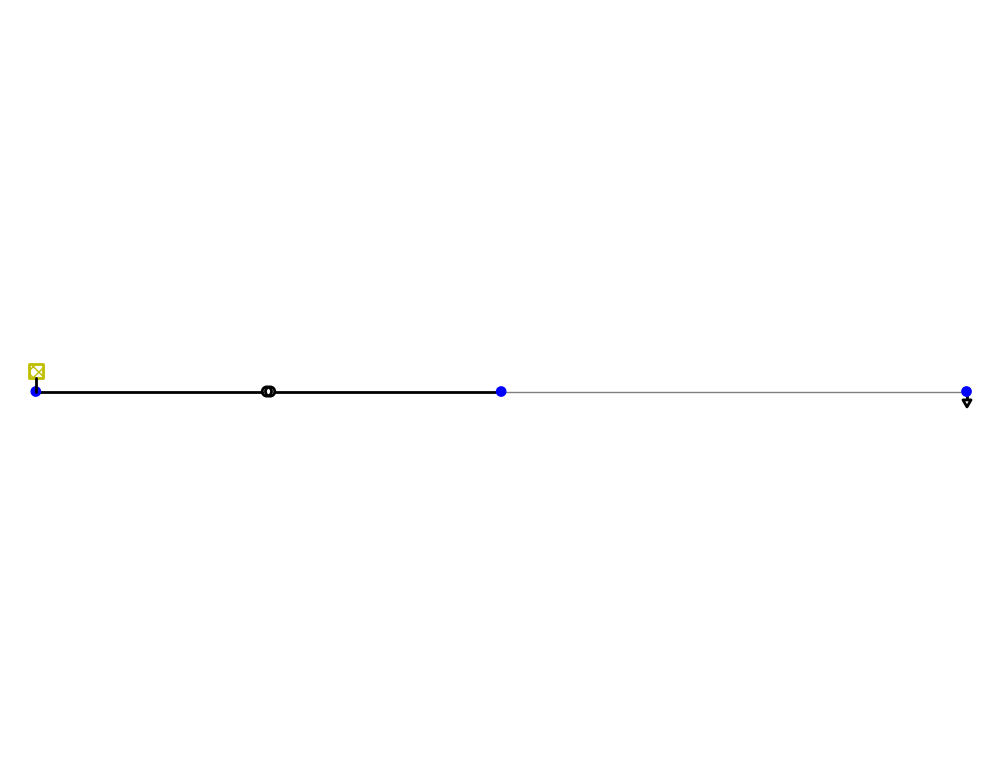

<Axes: >

In [113]:
pp.plotting.simple_plot(my_net, plot_loads=True, plot_gens=True, plot_sgens=True)

In [114]:
pp.runpp(my_net, numba=False)

In [115]:
my_net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
0,1.020000,0.000000,-0.107265,-0.052675
1,1.008843,-0.760126,0.000000,0.000000
2,0.964431,0.115859,0.100000,0.050000


In [118]:
# Unit descriptions in https://pandapower.readthedocs.io/en/latest/elements/line.html#result-parameters
my_net.res_line

,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,pl_mw,ql_mvar,i_from_ka,i_to_ka,i_ka,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,loading_percent
0,0.105392,0.050696,-0.1,-0.05,0.005392,0.000696,0.167325,0.167326,0.167326,1.008843,-0.760126,0.964431,0.115859,117.835208


## Beispielnetze und Simulation 

In [119]:
# https://pandapower.readthedocs.io/en/latest/networks/test.html#pandapower.networks.simple_four_bus_system
small_net = pp.networks.simple_four_bus_system()
# pp.plotting.simple_plot(small_net, plot_loads=True, plot_gens=True, plot_sgens=True)

### Beispielnetz aus Simbench inklusive Beispielzeitreihen

Simbench bietet viele Beispielnetze für unterschiedlichste Szenarien an: https://simbench.de/de/datensaetze/.
(Link funktionierte bei mir nicht mit Firefox).

Dieses Beispiel Notebook gibt einen guten Überblick über die möglichen Nutzungen der Netzwerke gemeinsam mit pandapower:
https://github.com/e2nIEE/simbench/blob/master/tutorials/simbench_grids_basics_and_usage.ipynb.

In [ ]:
# simbench - simbench.de - Zeitreihen von Verbrauchs/Einspeisedaten + Netze.
sb_code_lv = "1-LV-semiurb4--0-sw"

# creating a standard lv test network
net = sb.get_simbench_net(sb_code_lv)

In [ ]:
pp.plotting.simple_plot(net, plot_loads=True, plot_gens=True, plot_sgens=True)

In [ ]:
for key, df in net.profiles.items():
    print(f"{key}: {list(df.columns)}\n")

In [ ]:
# Get PV data from simbench
pv = net.profiles['renewables']
pv.head()

In [ ]:
# Make time the index, dayfirst for day.month.year and sort_index to allow slicing
pv.index = pd.to_datetime(pv['time'], dayfirst=True)
pv = pv['PV5'].sort_index()
pv.tail()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
fig.suptitle('Simbench PV profile')
pv['2016-01-01' : '2016-01-10'].plot(ax=axs[0])
pv['2016-06-01' : '2016-06-10'].plot(ax=axs[1])

In [ ]:
h0A = net.profiles['load'].set_index('time')['H0-A_pload']
h0A.index = pd.to_datetime(h0A.index, dayfirst=True)
h0A = h0A.sort_index()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
fig.suptitle('Simbench H0 profile')
h0A['2016-01-01' : '2016-01-10'].plot(ax=axs[0])
h0A['2016-06-01' : '2016-06-10'].plot(ax=axs[1])